In [1]:
!pip install numpy pandas torch torchvision yfinance

In [2]:
from IPython.display import display
from ipywidgets import FloatProgress
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf

# Download and generate daily return

In [3]:
def load_yf_data() -> pd.DataFrame:
    data = yf.download(
        ["SPY", "TLT", "GLD"], start="2015-01-01", end="2025-08-31", auto_adjust=True
    )
    data = data["Close"]
    return data[["SPY", "TLT", "GLD"]]


def calculate_returns(df) -> pd.DataFrame:
    df = np.log(df / df.shift(1))
    return df.dropna()


daily_close = load_yf_data()
daily_returns = calculate_returns(daily_close)
daily_returns

[*********************100%***********************]  3 of 3 completed


Ticker,SPY,TLT,GLD
Date,,,
2015-01-05,-0.018225,0.015587,0.014965
2015-01-06,-0.009464,0.017857,0.011334
2015-01-07,0.012384,-0.001977,-0.005909
2015-01-08,0.017589,-0.013332,-0.004217
2015-01-09,-0.008046,0.010893,0.011321
...,...,...,...
2025-08-25,-0.004411,-0.002876,-0.002418
2025-08-26,0.004178,-0.000576,0.007236
2025-08-27,0.002276,-0.001153,0.002017


# Constants and helpers

In [4]:
TRAIN_DAYS = 260 * 2  # number of days in training data for lstm
REBALANCE_INTERVAL = 30  # rebalance every 30 days


def split_dataset(df: pd.DataFrame):
    """
    Split data for walk forward testing
    """

    for idx in range(TRAIN_DAYS + REBALANCE_INTERVAL + 1, len(df) + 1, REBALANCE_INTERVAL):
        test_start = idx - REBALANCE_INTERVAL
        test_end = idx
        test_ds = df.iloc[test_start - REBALANCE_INTERVAL - 1 : test_end]

        train_start = test_start - 1 - TRAIN_DAYS
        train_end = test_start - 1
        train_ds = df.iloc[train_start:train_end]

        yield train_ds, test_ds


def expand_input(df: np.array) -> torch.Tensor:
    df = torch.Tensor(df)
    df2 = df**2
    return torch.concatenate([df, df2], axis=1)


def prepare_sequence(df: pd.DataFrame) -> tuple[torch.Tensor, torch.Tensor]:
    sequence_length = REBALANCE_INTERVAL
    prediction_length = REBALANCE_INTERVAL

    pr_df = expand_input(df[["SPY", "GLD", "TLT"]].to_numpy())
    pr_tensor = []
    target_tensor = []

    for i in range(1 + sequence_length + prediction_length, len(pr_df) + 1):
        pr_tensor.append(
            pr_df[i - 1 - prediction_length - sequence_length : i - 1 - prediction_length]
        )
        target_tensor.append(pr_df[i - prediction_length : i, :3])

    return (torch.Tensor(np.array(pr_tensor)), torch.Tensor(np.array(target_tensor)))

# Naive application of Markowitz model

In [5]:
def naive_weights(returns: pd.DataFrame, risk_free_rate: float = 0) -> pd.Series:
    """Max sharpe closed-form solution"""
    d = returns.shape[1]

    cov_matrix, mean_returns = returns.cov(), returns.mean(axis=0)
    excess_returns = mean_returns.values.reshape(d, 1) - risk_free_rate
    inv_cov = np.linalg.inv(cov_matrix)
    numerator = inv_cov @ excess_returns
    ones = np.ones((d, 1))
    denominator = ones.T @ numerator

    weights = numerator.reshape(d) / denominator[0][0]
    # normalized to ensure no leverage
    normalized_weights = weights / np.sum(np.abs(weights))
    return pd.Series(normalized_weights, index=returns.columns)


naive_returns = []

for _, test_df in split_dataset(daily_returns):
    in_df, out_df = test_df.iloc[:REBALANCE_INTERVAL], test_df.iloc[-REBALANCE_INTERVAL:]
    wts = naive_weights(in_df)
    naive_returns.append((wts.values * out_df).sum(axis=1))

naive_returns = pd.concat(naive_returns, axis=0)
naive_returns.expanding().sum()

Date
2017-01-30   -0.003907
2017-01-31   -0.000564
2017-02-01   -0.001650
2017-02-02   -0.000244
2017-02-03    0.004883
                ...   
2025-07-15    0.312104
2025-07-16    0.315165
2025-07-17    0.318856
2025-07-18    0.318691
2025-07-21    0.321896
Length: 2130, dtype: float64

# LSTM application of Markowitz model

### Model

In [6]:
class LSTMPortfolio(nn.Module):
    def __init__(self, num_composition: int, hidden_dim: int, nstack: int):
        super(LSTMPortfolio, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_composition = num_composition

        # The LSTM outputs hidden states with dimensionality hidden_dim.
        self.lstm = nn.LSTM(num_composition * 2, hidden_dim, nstack, batch_first=True)

        # The new few layers that map from hidden state space to weights
        linear_layers = [nn.Linear(hidden_dim, hidden_dim)]
        nn.init.kaiming_uniform_(linear_layers[-1].weight, a=0.01)

        self.linear_layers = nn.ModuleList(linear_layers)

        self.output_layer = nn.Linear(hidden_dim, num_composition)
        nn.init.kaiming_uniform_(self.output_layer.weight, a=0.01)

    def forward(self, pr_df: torch.Tensor) -> torch.Tensor:
        # takes return data sequences and passes them through the LSTM.
        _, (hn, _) = self.lstm(pr_df)
        #  This hidden state is then processed through our linear layers
        linear_in = hn[-1]

        out = linear_in
        for l in self.linear_layers:
            out = l(out)

        out = self.output_layer(out)

        # normalization: fully invested and not leverage
        out_weights = out / torch.sum(torch.abs(out), axis=1).view(-1, 1)
        return out_weights.view(-1, 1, self.num_composition)

### Loss function

In [7]:
def loss_function(weights: torch.Tensor, pr_df: torch.Tensor):
    """
    Loss function is negative sharpe
    """
    p_pr = torch.matmul(weights, pr_df.mT).view(-1, REBALANCE_INTERVAL)
    s, mu = torch.std_mean(p_pr, dim=-1)
    sharpe = mu / s
    return -torch.mean(sharpe)

### Training loop

In [8]:
def backtest(hidden_dim: int, nlayer: int, daily_returns: pd.DataFrame):
    model = LSTMPortfolio(3, hidden_dim, nlayer)
    print("*** Model architecture ***")
    print(model)

    optimizer = optim.SGD(model.parameters(), lr=1e-3)

    lstm_returns = []

    print("*** Train-Validation loop starts ***")
    fp = FloatProgress(min=0, max=1)
    display(fp)
    for train_df, test_df in split_dataset(daily_returns):     
        epoch = 0

        # The training loop runs for 100 epochs
        model.train()
        while epoch < 100:
            epoch += 1

            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network
            input_tensor, target_tensor = prepare_sequence(train_df)
            weights = model(input_tensor)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(weights, target_tensor)

            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            input_tensor, out_tensor = prepare_sequence(test_df)
            weights = model(input_tensor).view(-1)
            wts = weights.reshape(-1).cpu().numpy()

            lstm_returns.append((wts * test_df.iloc[-REBALANCE_INTERVAL:]).sum(axis=1))

            progress = (test_df.index[-1] - daily_returns.index[0]).value / (
                daily_returns.index[-1] - daily_returns.index[0]
            ).value
            fp.value = float(progress)

    lstm_returns = pd.concat(lstm_returns, axis=0)
    print("*** Train-Validation done ***")
    return lstm_returns.dropna()

In [9]:
print(f"ds {daily_returns.index[0]} - {daily_returns.index[-1]}")
lstm_returns = backtest(8, 8, daily_returns)
lstm_returns

ds 2015-01-05 00:00:00 - 2025-08-29 00:00:00
*** Model architecture ***
LSTMPortfolio(
  (lstm): LSTM(6, 8, num_layers=8, batch_first=True)
  (linear_layers): ModuleList(
    (0): Linear(in_features=8, out_features=8, bias=True)
  )
  (output_layer): Linear(in_features=8, out_features=3, bias=True)
)
*** Train-Validation loop starts ***


FloatProgress(value=0.0, max=1.0)

*** Train-Validation done ***


Date
2017-01-30   -0.001467
2017-01-31    0.006979
2017-02-01   -0.002685
2017-02-02    0.002175
2017-02-03    0.003251
                ...   
2025-07-15   -0.003530
2025-07-16    0.001836
2025-07-17    0.004501
2025-07-18   -0.000627
2025-07-21    0.000597
Length: 2130, dtype: float64

### Compute sharpe

In [12]:
naive_sharpe = (naive_returns.mean() / naive_returns.std()) * np.sqrt(252)
print(f"Naive sharpe: {naive_sharpe}")

lstm_sharpe = (lstm_returns.mean() / lstm_returns.std()) * np.sqrt(252)
print(f"LSTM sharpe: {lstm_sharpe}")

Naive sharpe: 0.3536604730706708
LSTM sharpe: 0.6965676910907087


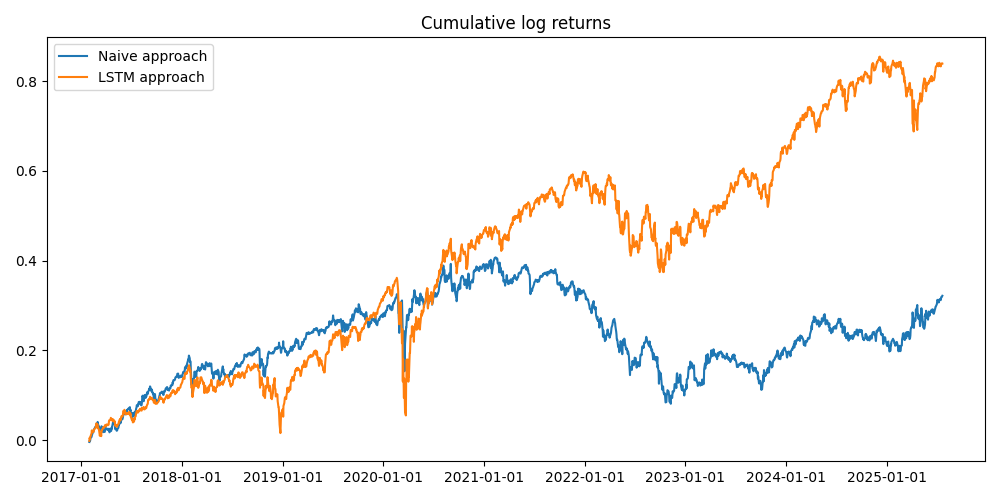

In [13]:
%matplotlib widget

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

ax.set_title("Cumulative log returns")

ax.plot(naive_returns.index, naive_returns.expanding().sum(), label="Naive approach")
ax.plot(lstm_returns.index, lstm_returns.expanding().sum(), label="LSTM approach")

ax.legend()
fig.tight_layout()